# 1083 Albumin Initial ML

### By: Ian Weimer

## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
import math
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import cross_val_score
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import warnings
from sklearn.compose import make_column_transformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import balanced_accuracy_score
import graphviz
import pydotplus
from imblearn.over_sampling import SMOTE, SMOTENC
pd.set_option('display.max_columns', None)

## Load Albumin Data From Pre-processing and Exploratory Analysis

In [2]:
df = pd.read_csv('N04_matched.csv')

In [3]:
# drop insignificant vars

#df.drop(columns = ['bed_size', 'Cirrhosis', 'tenant'], inplace=True)

In [4]:
df.head()

encounterid  ICU  Cirrhosis  CCI  qSOFA  SEWS  \
0  1684f4f6-2f4a-4441-8af9-c4165f550d54    0          0    0      1     2   
1  8a39cae9-5cb0-4aa6-9d0c-dd11d86d3b09    0          0    1      0     0   
2  6a0962cf-b9f7-4c4f-ba75-fc5207722a36    0          1    0      1     2   
3  3639f1d7-780b-4766-b9e5-b70db8f617b5    0          0    0      1     3   
4  59c8a1ba-0aa9-4a0e-9764-d96eb5a2df03    0          0    4      1     3   

   propensity_score  propensity_logit  albumin_24hrs  \
0          0.635797          0.557167              1   
1          0.370413         -0.530446              1   
2          0.855310          1.776873              1   
3          0.671801          0.716343              1   
4          0.676695          0.738624              1   

                               personid  LOS_days  90_day_mortality  \
0  0bd4cf71-9232-4d6c-bb76-b580a813d0b8  0.743750                 0   
1  21b88c50-de34-435d-8c60-357d6d8ca892  6.963056                 0   
2  40cd7ee5-00d8-45af-8781-7ea6e956d8e9  4.140972                 0   
3  48531d48-8a10-46f1-b80d-252e08c651cd  1.348611                 0   
4  6ee7780f-14d7-4733-a47f-0b6c97e32870  9.985417                 0   

   90_day_readmission  hospital_free_days  albumin_timing  albumin  
0                 1.0                  36             1.0        1  
1                 0.0                  83             2.0        1  
2                 0.0                  14             2.0        1  
3                 0.0                   4             1.0        1  
4                 1.0                   9             2.0        1

In [5]:
df.shape

(3139, 16)

## Select Only Patients Who Lived (Removing Patients in 0 Class Who Died)

In [6]:
df = df.loc[df['90_day_mortality'] == 0]

In [7]:
df.shape

(2934, 16)

## Look at outcomes distributions between patients who did and didn't receive albumin within 24 hrs

In [8]:
ra_90d_a24 = df[df['albumin_24hrs'] == 1]['90_day_readmission'].value_counts()
print(ra_90d_a24)

0.0    822
1.0    632
Name: 90_day_readmission, dtype: int64


In [9]:
def binary_pct(var):
    pct = (var[1]/(var[1]+var[0])) * 100
    return pct

binary_pct(ra_90d_a24)

43.46629986244842

In [10]:
ra_90d = df[df['albumin_24hrs'] == 0]['90_day_readmission'].value_counts()
print(ra_90d)

0.0    831
1.0    649
Name: 90_day_readmission, dtype: int64


In [11]:
binary_pct(ra_90d)

43.851351351351354

In [12]:
df.drop(columns=['propensity_score', 'propensity_logit', 'encounterid', 'personid', 'albumin', 'albumin_timing'], inplace=True)

In [13]:
df.drop(columns=['90_day_mortality', 'LOS_days', 'hospital_free_days'], inplace=True)

In [14]:
# remove variables

# df.drop(columns=['mass_transfusion', 'anemia_status', 'qSOFA', 'hemorrhagic', 'bl_albumin_value', 'SAPS'], inplace=True)
# df.drop(columns=['qSOFA', 'bl_albumin_value', 'SAPS'], inplace=True)

In [15]:
df.describe()

ICU    Cirrhosis          CCI        qSOFA        SEWS  \
count  2934.000000  2934.000000  2934.000000  2934.000000  2934.00000   
mean      0.098841     0.195297     3.042945     0.450579     1.06135   
std       0.298500     0.396496     2.558193     0.587497     1.41794   
min       0.000000     0.000000     0.000000     0.000000     0.00000   
25%       0.000000     0.000000     0.000000     0.000000     0.00000   
50%       0.000000     0.000000     3.000000     0.000000     1.00000   
75%       0.000000     0.000000     5.000000     1.000000     2.00000   
max       1.000000     1.000000    14.000000     3.000000     9.00000   

       albumin_24hrs  90_day_readmission  
count    2934.000000         2934.000000  
mean        0.495569            0.436605  
std         0.500066            0.496049  
min         0.000000            0.000000  
25%         0.000000            0.000000  
50%         0.000000            0.000000  
75%         1.000000            1.000000  
max         1.000000            1.000000

In [16]:
#df = df[['CCI', 'unknown_albumin_type', 'albumin_24hrs', '25_percent_albumin', 'LOS_days']]

## Modeling

In [17]:
# establish target feature, LOS_days, as y feature
y = df['90_day_readmission']
# drop target feature from features dataframe
X = df.drop(columns = ['90_day_readmission'], axis = 1)
# save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

In [18]:
cols

Index(['ICU', 'Cirrhosis', 'CCI', 'qSOFA', 'SEWS', 'albumin_24hrs'], dtype='object')

## Standardize Data

In [19]:
#cols = X.columns

#instantiate min-max scaling object
#mm = MinMaxScaler()
# fit and transform feature dataframe
#X = pd.DataFrame(mm.fit_transform(X))
# reassign column names so new dataframe has corresponding names
#X.columns = cols

In [20]:
X.head()

ICU  Cirrhosis  CCI  qSOFA  SEWS  albumin_24hrs
0    0          0    0      1     2              1
1    0          0    1      0     0              1
2    0          1    0      1     2              1
3    0          0    0      1     3              1
4    0          0    4      1     3              1

## Train Test Split

In [21]:
sm = SMOTENC(random_state=42, categorical_features = [0, 1, 3, 5])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
#sm = SMOTEN(random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#X_train, y_train = sm.fit_resample(X_train, y_train)

In [23]:
y_train.value_counts()

1.0    1318
0.0    1318
Name: 90_day_readmission, dtype: int64

In [24]:
# train test split from target feature series and the predicting feature dataframe (set test size to 20% of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 33)

## Multinomial Logistic Regression

In [65]:
# instantiate a Logistic Regression model without an intercept, 'liblinear' solver method
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# fit the model to X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial')

Feature: ICU Score: 0.06945
Feature: Cirrhosis Score: 0.17327
Feature: CCI Score: 0.01268
Feature: qSOFA Score: -0.05047
Feature: MELD Score: -0.00252
Feature: SEWS Score: -0.01913
Feature: albumin_24hrs Score: 0.07462


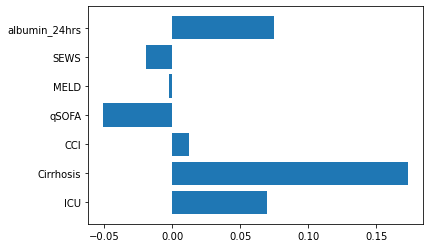

In [66]:
# general quick feature importance
# get coefficients for importance
# coefficients represent the log odds that an observation is in the
# target class, given the values of its X variables

importance = logreg.coef_[0]
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

               Importance
Cirrhosis        1.189190
albumin_24hrs    1.077478
ICU              1.071922
CCI              1.012763
MELD             0.997485
SEWS             0.981053
qSOFA            0.950779


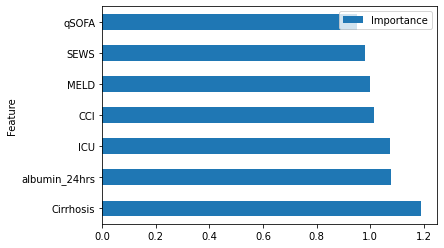

In [67]:
# convert log odds into regular odds with exponentiation
# np.exp()
# and list values, visualize in bar plot

odds = np.exp(logreg.coef_[0])
feature_importance = \
            pd.DataFrame(odds, 
             X.columns, 
             columns=['Importance'])\
            .sort_values(by='Importance', ascending=False)
        
ax = feature_importance.plot.barh(xlabel='Feature', ylabel='Importance')
print(feature_importance)
plt.show()

In [68]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

In [69]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[612 528]
 [479 661]]


In [70]:
# model metrics for training set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.56      0.54      0.55      1140
         1.0       0.56      0.58      0.57      1140

    accuracy                           0.56      2280
   macro avg       0.56      0.56      0.56      2280
weighted avg       0.56      0.56      0.56      2280



In [71]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[159 126]
 [102 104]]


In [72]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.61      0.56      0.58       285
         1.0       0.45      0.50      0.48       206

    accuracy                           0.54       491
   macro avg       0.53      0.53      0.53       491
weighted avg       0.54      0.54      0.54       491



## 5: Decision Tree 

In [73]:
# instantiate a decision tree model
# max_depth limits depth of tree, helps prevent overfitting training data
# max_depth 5
dt = tree.DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)
# fit the model to X and y training sets
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

Feature: ICU Score: 0.04991
Feature: Cirrhosis Score: 0.22836
Feature: CCI Score: 0.15786
Feature: qSOFA Score: 0.04754
Feature: MELD Score: 0.35383
Feature: SEWS Score: 0.09301
Feature: albumin_24hrs Score: 0.06949


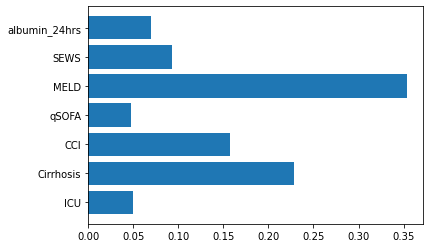

In [74]:
# get importance from decision tree model
importance = dt.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()

In [75]:
# generate model prediction data for train and test sets
y_hat_train = dt.predict(X_train)
y_hat_test = dt.predict(X_test)

In [76]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[778 362]
 [590 550]]


In [77]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

         0.0       0.57      0.68      0.62      1140
         1.0       0.60      0.48      0.54      1140

    accuracy                           0.58      2280
   macro avg       0.59      0.58      0.58      2280
weighted avg       0.59      0.58      0.58      2280



In [78]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[187  98]
 [123  83]]


In [79]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

         0.0       0.60      0.66      0.63       285
         1.0       0.46      0.40      0.43       206

    accuracy                           0.55       491
   macro avg       0.53      0.53      0.53       491
weighted avg       0.54      0.55      0.54       491



In [80]:
feature_names = X_train.columns.tolist()
class_names = ['Not Readmitted', 'Readmitted']

fig = plt.figure(figsize=(60,30))
_ = tree.plot_tree(dt,
                   fontsize=8,
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True)

In [81]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=feature_names,  
                     class_names=class_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_png('90DRA_DT_D7_PSM_MATCHED.png')

True

## Random Forest

In [79]:
rf = RandomForestClassifier(max_depth=8, min_samples_leaf=100)
# fit the model to X and y training sets
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=100)

In [80]:
# generate model prediction data for train and test sets
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)

In [81]:
# confusion_matrix for actual y_train and predicted y_train
cnf_matrix = confusion_matrix(y_train, y_hat_train)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[19668 14674]
 [14540 19802]]


In [82]:
# model metrics for train set (Precision, Recall, Accuracy, F1)
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57     34342
           1       0.57      0.58      0.58     34342

    accuracy                           0.57     68684
   macro avg       0.57      0.57      0.57     68684
weighted avg       0.57      0.57      0.57     68684



In [83]:
# confusion_matrix for actual y_test and predicted y_test
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[4861 3649]
 [1780 1932]]


In [84]:
# model metrics for test set (Precision, Recall, Accuracy, F1)
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.73      0.57      0.64      8510
           1       0.35      0.52      0.42      3712

    accuracy                           0.56     12222
   macro avg       0.54      0.55      0.53     12222
weighted avg       0.61      0.56      0.57     12222



Feature: anemia_status Score: 0.12464
Feature: CCI Score: 0.40683
Feature: albumin_24hrs Score: 0.04143
Feature: qSOFA Score: 0.05016
Feature: SAPS Score: 0.37694


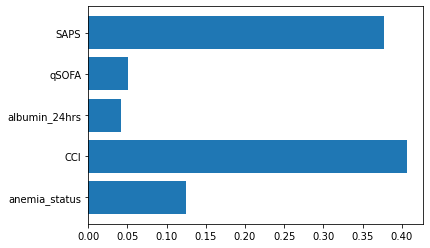

In [85]:
# get importance from decision tree model
importance = rf.feature_importances_
# summarize feature importance
labels = []
for i,v in enumerate(importance):
    print('Feature: %s Score: %.5f' % (cols[i], v))
    labels.append(cols[i])
# plot feature importance
pyplot.barh(labels, importance)
pyplot.show()